# Papers with Code: Unsupervised Seismic Waveform Classification

## 2D Synthetic:

This first step is about getting our tools ready. We are importing several Python libraries that will help us with numerical operations, plotting, and machine learning:
* **numpy**: A powerful library for handling arrays and mathematical operations.
* **matplotlib.pyplot**: The main tool for creating plots and visualizations.
* **KMeans**: An algorithm from the scikit-learn library that will help us group similar waveforms together.
* **silhouette_score**: A metric to evaluate the quality of our clustering results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Here, we are creating a simplified model of the Earth's subsurface. In geophysics, the boundaries between different rock layers are represented by **reflection coefficients (RC)**. These coefficients determine how much seismic energy is reflected at each boundary.\n"

We are creating a 2D array (a grid) where most of the values are zero, but we are defining a specific set of RC values in the middle row to simulate a geological feature.

In [ ]:
# Define the values for the 4th layer (row) in our geological model
rc_values = [-0.9, -0.7, -0.5, -0.3, -0.1, 0, 0.1, 0.3, 0.5, 0.7, 0.9, 1, 0.9, 0.7, 0.5, 0.3, 0.1, 0, -0.1, -0.3, -0.5, -0.7, -0.9]

# Create a 7x10 array of zeros
rc = np.zeros((7, len(rc_values)))

# Replace the 4th row
rc[3, :] = rc_values

This plot shows our simple geological model. The horizontal axis represents different locations (traces), and the vertical axis represents depth (or time).

From a geoscience perspective, the bright and dark spots in the middle of the plot represent the boundaries between different rock layers. The values (from -1 to 1) indicate the strength and polarity of the reflection. A high positive value (white) might represent a large increase in rock density and velocity (e.g., going from shale to limestone), while a high negative value (black) represents a decrease.

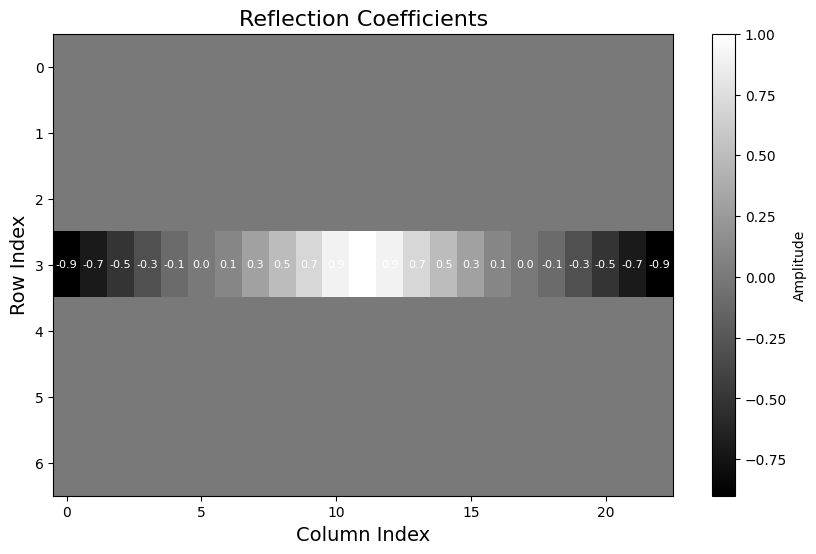

In [3]:
# Plot the rc array
plt.figure(figsize=(10, 6))
plt.imshow(rc, cmap='gray', aspect='auto')
plt.title('Reflection Coefficients', fontsize=16)
plt.xlabel('Column Index', fontsize=14)
plt.ylabel('Row Index', fontsize=14)

# Annotate the 4th row values
for col, value in enumerate(rc_values):
    plt.text(col, 3, f"{value:.1f}", ha='center', va='center', color='white', fontsize=8)

plt.colorbar(label='Amplitude')
plt.show()

A seismic wavelet is a short pulse of energy that we theoretically send into the ground. The shape of this wavelet is important for interpreting seismic data. Here, we are defining the parameters for a **Ricker wavelet**, which is a standard, zero-phase wavelet commonly used in geophysics. It can be defining using the following parameters:
* **freq**: The dominant frequency of the wavelet (in Hz).
* **tn**: The length of the wavelet (in milliseconds).
* **dt**: The sampling interval (in milliseconds).

In [4]:
# Define parameters
freq = 50
tn = 50
dt = 0.1

This step creates a time array that will serve as the vertical axis for our wavelet. The time is centered around zero to create a symmetric wavelet.

In [ ]:
# Create time array
t = np.arange(-tn / 2, tn / 2 + dt, dt) / 1000

Using the parameters we defined previously, we now generate the Ricker wavelet using its mathematical formula. This wavelet will be used to create our synthetic seismic data.

The Ricker wavelet is defined by the following equation:

$$
w(t) = \left(1 - 2\pi^2 f^2 t^2\right) \exp\left(-\pi^2 f^2 t^2\right)
$$

where:
- \($w(t)$\) is the wavelet amplitude at time \($t$\)
- \($f$\) is the dominant frequency

In [6]:
# Define Ricker Wavelet
ricker = (1 - 2 * np.pi**2 * freq**2 * t**2) * np.exp(-np.pi**2 * freq**2 * t**2)

This plot shows the shape of our 50 Hz Ricker wavelet. In seismic interpretation, the central peak (blue) and the two side troughs (red) are characteristic features. The shape of the wavelet affects how geological features will appear in the final seismic section. A higher frequency wavelet provides better resolution but penetrates less deeply into the subsurface.

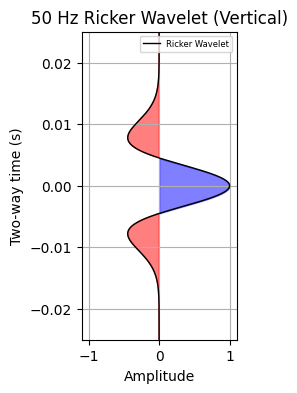

In [7]:
# Plot Ricker wavelet (Vertical)
plt.figure(figsize=(2, 4))
plt.plot(ricker, t, lw=1, color='black', label='Ricker Wavelet')
plt.fill_betweenx(t, ricker, 0, ricker > 0.0, color='blue', alpha=0.5)
plt.fill_betweenx(t, ricker, 0, ricker < 0.0, color='red', alpha=0.5)
plt.title('%d Hz Ricker Wavelet (Vertical)' % freq, fontsize=12)
plt.xlabel('Amplitude', fontsize=10)
plt.ylabel('Two-way time (s)', fontsize=10)
plt.xlim((-1.1, 1.1))
plt.ylim((min(t), max(t)))
plt.grid()
plt.legend(fontsize = 6, loc = 'upper right')
plt.show()

We are initializing an empty 2D array that will hold our final synthetic seismic section. The dimensions are set to match the length of our wavelet and the number of traces in our geological model.

In [8]:
# Initialize synth_seismic with shape (len(ricker), number of columns in rc)
synth_seismic = np.zeros((len(ricker), rc.shape[1]))

This is the core step of creating our synthetic seismic data. We use a mathematical operation called **convolution**. In simple terms, we are 'stamping' our Ricker wavelet at each reflection coefficient in our geological model.

The result is a synthetic seismic trace for each location, which simulates what a geophone would record in a real seismic survey.

In [9]:
# Convolve the wavelet with each column of the RC array
for col in range(rc.shape[1]):
    # Perform convolution and add the result to the synth_seismic array
    synth_seismic[:, col] = np.convolve(rc[:, col], ricker, mode='same')

This plot shows our final synthetic seismic section. From a geoscience perspective, this is what a 2D seismic line might look like. The different 'wiggles' (traces) show how the seismic wave has reflected off the different rock layers we defined.

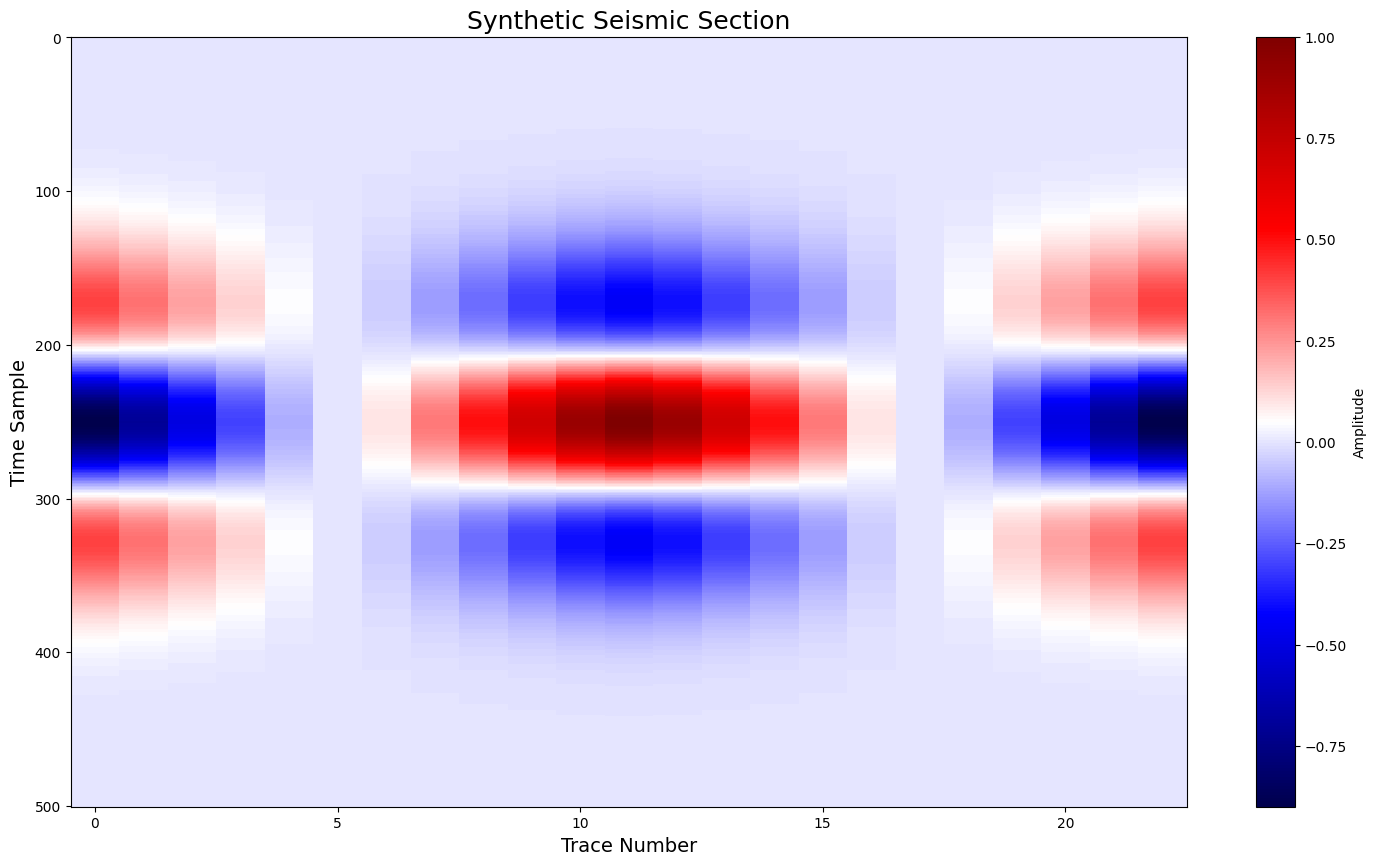

synth_seismic shape: (501, 23)


In [10]:
# Plot the synthetic seismic section
plt.figure(figsize=(18, 10))
plt.imshow(synth_seismic, cmap='seismic', aspect='auto', interpolation='none')
plt.colorbar(label='Amplitude')
plt.title('Synthetic Seismic Section', fontsize=18)
plt.xlabel('Trace Number', fontsize=14)
plt.ylabel('Time Sample', fontsize=14)
plt.show()

# Display the dimensions of the synthetic seismic array
print(f"synth_seismic shape: {synth_seismic.shape}")

The K-Means algorithm expects each seismic trace to be a single sample (a row in our data array). Our `synth_seismic` array has traces as columns, so we need to **transpose** it. This is a common data preparation step in machine learning.

In [11]:
# Transpose the synth_seismic array to make each column a sample
synth_seismic_T = synth_seismic.T  # Shape becomes (23, 501)

Now we decide how many different groups (or **clusters**) of waveforms we want to find. This is a key parameter for the K-Means algorithm. For this example, we'll start with 5 clusters, but we'll use a technique called the 'Elbow Method' to see if this is a good choice.

In [12]:
# Number of clusters for K-Means
num_clusters = 5  # You can change this depending on your needs

Here, we apply the K-Means algorithm to our seismic data. The algorithm will group the 23 seismic traces into 5 clusters based on their shape. Traces within the same cluster are more similar to each other than to those in other clusters.

In [13]:
# Perform K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(synth_seismic_T)


To find the optimal number of clusters, we'll use the **Elbow Method**. This involves running the K-Means algorithm for a range of cluster numbers and plotting the 'Sum of Squared Errors' (SSE). The 'elbow' of the curve on the plot will suggest the best number of clusters.

In [14]:
# Perform K-Means clustering with multiple cluster numbers for the elbow method
sse = []  # Sum of Squared Errors
silhouette_scores = []  # Silhouette Scores
k_range = range(2, 11)  # Range of clusters

This loop runs the K-Means algorithm for each number of clusters in our defined range (from 2 to 10). For each run, it calculates the SSE and the silhouette score, which we'll use to evaluate the results.

In [15]:
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(synth_seismic.T)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(synth_seismic.T, kmeans.labels_))

This plot shows the Sum of Squared Errors (SSE) for different numbers of clusters. We are looking for the 'elbow' point, where the rate of decrease in SSE slows down significantly. In this case, the elbow appears to be at **k=5**, which suggests that 5 is a good number of clusters for our data. This validates our initial choice.

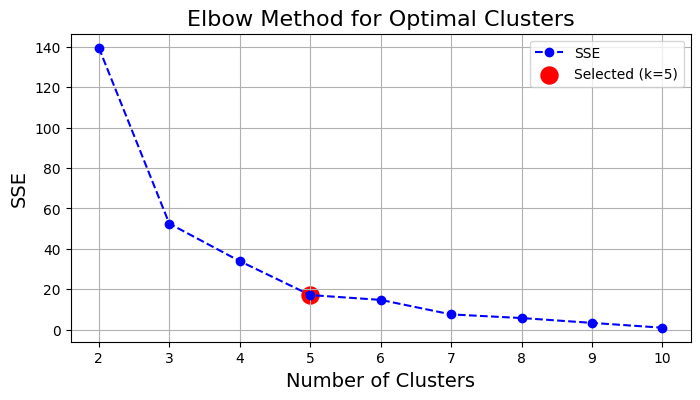

In [16]:
# Elbow Method Plot
plt.figure(figsize=(8, 4))
plt.plot(k_range, sse, marker='o', linestyle='--', color='blue', label='SSE')
plt.scatter(5, sse[3], color='red', s=150, label='Selected (k=5)')  # Highlight k=5 (index 3 because k=5 is the 4th in range)
plt.title('Elbow Method for Optimal Clusters', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('SSE', fontsize=14)
plt.grid()
plt.legend()
plt.show()

To make our results easy to interpret, we'll assign a unique color to each cluster. This will help us visualize the spatial distribution of the different waveform groups.

In [17]:
# Define consistent cluster colors
waveform_colors = ['red', 'blue', 'green', 'orange', 'purple']  # Colors for each cluster
custom_cmap = ListedColormap(waveform_colors)


Now, we create a new seismic section where each trace is colored according to the cluster it belongs to. This will give us a 'seismic facies' map, where each color represents a different type of seismic response.

In [18]:
# Create a classified synthetic seismic section
colored_synth_seismic = np.zeros_like(synth_seismic)
for col in range(synth_seismic.shape[1]):
    colored_synth_seismic[:, col] = cluster_labels[col]

The following plots show the final results of our unsupervised classification.

-  **Left Plot**: This shows the 'seismic facies' map. Each color corresponds to one of the 5 waveform clusters we identified. This allows us to see the spatial distribution of different seismic responses. For example, the central part of our model is clearly delineated by the green, orange, and purple facies.
- **Right Plot**: This plot overlays the facies map on top of the original seismic data. This is a powerful visualization that allows us to directly compare the classification with the underlying seismic amplitudes. It helps to confirm that the algorithm has successfully grouped traces with similar characteristics.
   

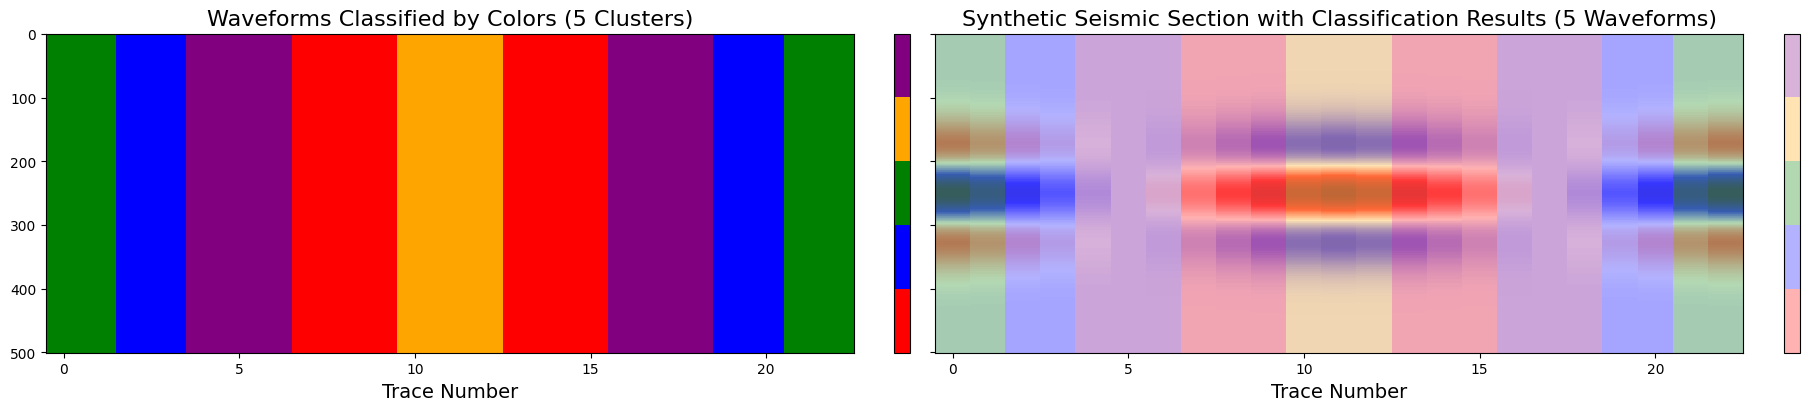

In [19]:
# Create the figure with 3 subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 4), constrained_layout=True, sharey=True)

# Second subplot: Only the waveforms classified by colors
im1 = axs[0].imshow(colored_synth_seismic, cmap=custom_cmap, aspect='auto', interpolation='none')
axs[0].set_title('Waveforms Classified by Colors (5 Clusters)', fontsize=16)
axs[0].set_xlabel('Trace Number', fontsize=14)
fig.colorbar(im1, ax=axs[0], orientation='vertical').set_ticks([])  # Remove ticks and labels

# Third subplot: Overlay of seismic amplitude and classification
axs[1].imshow(synth_seismic, cmap='seismic', aspect='auto', interpolation='none', alpha=0.7)
im2 = axs[1].imshow(colored_synth_seismic, cmap=custom_cmap, aspect='auto', interpolation='none', alpha=0.3)
axs[1].set_title('Synthetic Seismic Section with Classification Results (5 Waveforms)', fontsize=16)
axs[1].set_xlabel('Trace Number', fontsize=14)
fig.colorbar(im2, ax=axs[1], orientation='vertical').set_ticks([])  # Remove ticks and labels

# Show the figure
plt.show()


Finally, we can look at the average waveform for each cluster. These are the 'representative' waveforms that the K-Means algorithm has identified.

From a geoscience perspective, these different waveform shapes are very meaningful. They can correspond to different **seismic facies**, which in turn can represent different geological features. For example:
- **Waveform 1 and 2 (Red and Blue)** might represent background shales or a consistent lithology.
- **Waveform 3, 4, and 5 (Green, Orange, Purple)** show more complex shapes, which could indicate features like thin beds, channel fills, or lateral changes in rock properties.

By identifying and mapping these waveforms, a geoscientist can build a more detailed and accurate interpretation of the subsurface geology, which is crucial for tasks like hydrocarbon exploration or reservoir characterization.

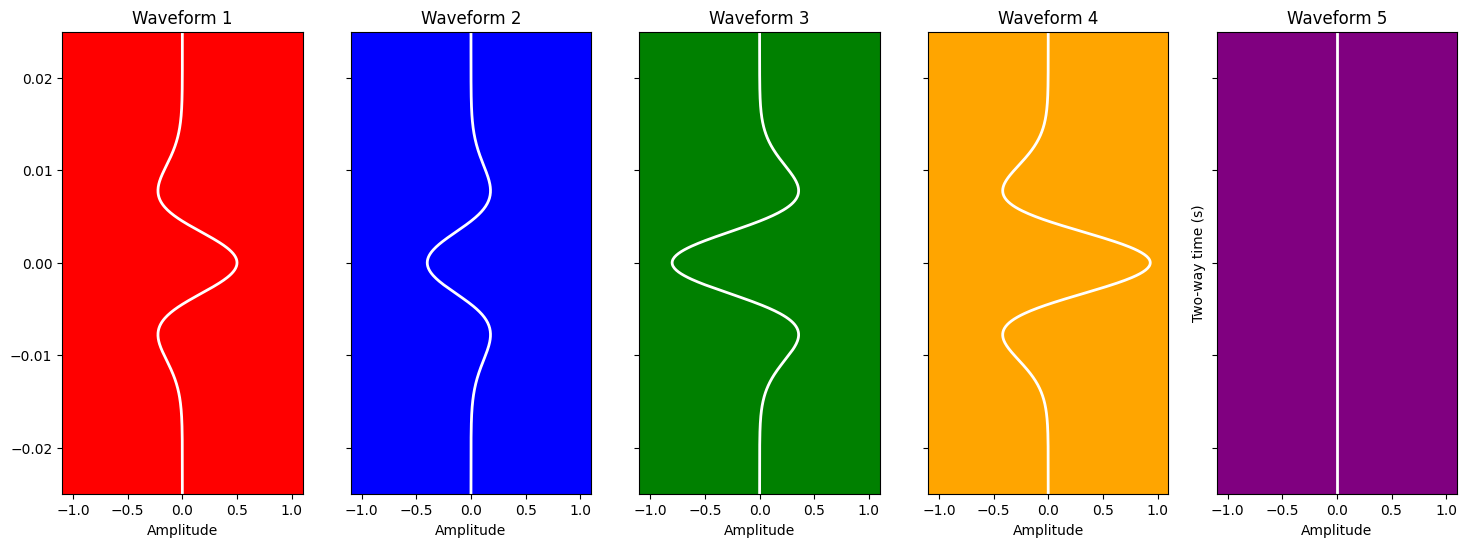

In [ ]:
# Extract unique clusters
unique_clusters = np.unique(cluster_labels)

# Create subplots for each cluster
fig, axs = plt.subplots(1, num_clusters, figsize=(18, 6), sharey=True)

# Plot each cluster's average waveform
for i, cluster in enumerate(unique_clusters):
    # Extract traces belonging to the current cluster
    cluster_indices = np.where(cluster_labels == cluster)[0]
    # Compute the average waveform for the cluster
    average_waveform = np.mean(synth_seismic[:, cluster_indices], axis=1)
    
    # Plot the waveform vertically
    axs[i].plot(average_waveform, t, color='white', lw=2)
    axs[i].set_facecolor(waveform_colors[cluster])  # Set background color to cluster color
    axs[i].set_xlim([-1.1, 1.1])  # Match the Ricker wavelet's amplitude range
    axs[i].set_ylim([min(t), max(t)])  # Ensure the y-axis covers the full time range
    axs[i].set_title(f'Waveform {cluster + 1}', fontsize=12)
    axs[i].set_xlabel('Amplitude', fontsize=10)  # Add x-label for each subplot
    
# Adjust layout for the subplots
#fig.tight_layout(pad=0, w_pad=0, h_pad=0)  # Remove spacing between subplots
plt.ylabel('Two-way time (s)', fontsize=10)  # Add y-label to the first subplot

# Show the figure
plt.show()